# CS210 Data Management for Data Science Course Project
## LinkedIn Job Postings Success Analysis
### Research Question: What factors in LinkedIn job postings influence the number of applications received, and how can employers optimize these factors to increase engagement?
#### Manpreet Kaur (mk2016), Simrat Kaur (sk2581) & Keerthi Peruka (kp1092)

## Task 1 - Preparing the Dataset for LinkedIn Job Posting Success Analysis

### 1.1 Importing Required Libraries

In [1]:
# All import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sqlalchemy import create_engine
from collections import Counter

### 1.2 Reading and Inspecting the Data

In [2]:
# Load dataset from CSV file postings.csv
df = pd.read_csv('postings.csv')

# Display the first 20 rows
df.head(20)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0
5,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,HOURLY,"Raleigh, NC",1481176.0,9.0,NaN,...,NaN,1.713456e+12,NaN,0,INTERNSHIP,USD,BASE_SALARY,35360.0,27601.0,37183.0
6,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,YEARLY,United States,81942316.0,7.0,NaN,...,NaN,1.712861e+12,NaN,0,CONTRACT,USD,BASE_SALARY,180000.0,NaN,NaN
7,112576855,NaN,Building Engineer,Summary: Due to the pending retirement of our ...,120000.0,YEARLY,"San Francisco, CA",NaN,2.0,NaN,...,NaN,1.712443e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,105000.0,94101.0,6075.0
8,1218575,Children's Nebraska,Respiratory Therapist,"At Children’s, the region’s only full-service ...",NaN,NaN,"Omaha, NE",721189.0,3.0,NaN,...,• Requires the ability to communicate effectiv...,1.712348e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,68102.0,31055.0
9,2264355,Bay West Church,Worship Leader,It is an exciting time to be a part of our chu...,NaN,MONTHLY,"Palm Bay, FL",28631247.0,5.0,350.0,...,"Knowledge, Skills and Abilities: 1. Proficient...",1.712456e+12,NaN,0,PART_TIME,USD,BASE_SALARY,4200.0,32905.0,12009.0


## Task 2 - Cleaning and Preprocessing LinkedIn Job Posting Data

### 2.1 Cleaning and Standardizing the Datase

In [3]:
# Removed rows with missing values
df = df.dropna(subset=['title', 'description', 'location', 'max_salary', 'min_salary', 'applies'])

# Fill missing values in 'max_salary' and 'min_salary' with their median values
df['max_salary'] = df['max_salary'].fillna(df['max_salary'].median())
df['min_salary'] = df['min_salary'].fillna(df['min_salary'].median())

# Convert salaries to standard format (USD per year)
df['normalized_salary'] = np.where(
    df['pay_period'] == 'HOURLY', df['max_salary'] * 2080,
    np.where(df['pay_period'] == 'MONTHLY', df['max_salary'] * 12, df['max_salary'])
)

### 2.2 Adding Derived Features

In [4]:
# Convert time columns to datetime format
time_columns = ['original_listed_time', 'expiry', 'closed_time', 'listed_time']

for col in time_columns:
    df[col] = pd.to_datetime(df[col], unit='ms', errors='coerce')

# Create new columns for analysis
df['salary_range'] = df['max_salary'] - df['min_salary']
df['job_duration'] = (df['expiry'] - df['original_listed_time']).dt.days
df['remote_allowed'] = df['remote_allowed'].map({0: 'No', 1: 'Yes'})

### 2.3 Removing Outliers

In [5]:
# Calculate Q1, Q3, and IQR
Q1 = df['max_salary'].quantile(0.25)
Q3 = df['max_salary'].quantile(0.75)
IQR = Q3 - Q1

# Define condition to identify outliers
outlier_condition = (df['max_salary'] < (Q1 - 1.5 * IQR)) | (df['max_salary'] > (Q3 + 1.5 * IQR))
outliers = df[outlier_condition]

# Print the outliers
print("Outliers found in max_salary:\n", outliers)

# Remove outliers from dataset
df = df[~outlier_condition]

# Save cleaned data to a new CSV file called 'cleaned_postings.csv'
df.to_csv('cleaned_postings.csv', index=False)

# Display cleaned Dataset
print("Cleaned Dataset:")
print(df.head())

Outliers found in max_salary:
             job_id              company_name  \
1217    3884434376              Tandym Group   
2206    3884443144                 Ascendion   
2667    3884809118              PreXion CBCT   
3844    3884856265                  OneForce   
4790    3884924066    Girl Scouts of the USA   
...            ...                       ...   
116010  3905860954          Goliath Partners   
116465  3905869603          Goliath Partners   
118302  3906093549            Selby Jennings   
118690  3906098174      Coda Search│Staffing   
118769  3906099456  Stanley House Consulting   

                                                    title  \
1217                                General Dermatologist   
2206    Intellectual Property / Patent Partner (Litiga...   
2667                       Dental Territory Sales Manager   
3844                   Fractional CMO Partner (Marketing)   
4790                              Chief Marketing Officer   
...                       

## Task 3 - Data Storage and Aggregation

### 3.1 Saving Summary Statistics to SQLite

In [6]:
# Calculate 'mean_salary' and 'top_location_counts' to store
mean_salary = df['normalized_salary'].mean()
top_location_counts = df['location'].value_counts().head(10)

# Create a DataFrame for storage of these calculated statistics
statistics_df = pd.DataFrame({
    'Statistic': ['Mean Salary'] + list(top_location_counts.index),
    'Value': [mean_salary] + list(top_location_counts.values)
})

# Save statistics to SQLite database
conn = sqlite3.connect('linkedin_postings.db')
statistics_df.to_sql('job_posting_statistics', conn, if_exists='replace', index=False)

# Print stored statistics
print("Statistics stored in SQLite database:")
print(statistics_df)

# Close database connection
conn.close()

Statistics stored in SQLite database:
                          Statistic          Value
0                       Mean Salary  209066.906384
1                     United States    1240.000000
2                      New York, NY     476.000000
3   New York City Metropolitan Area     203.000000
4                       Chicago, IL     125.000000
5                   Los Angeles, CA     123.000000
6                       Houston, TX     104.000000
7                       Atlanta, GA     102.000000
8                 San Francisco, CA     101.000000
9                       Seattle, WA      99.000000
10                    San Diego, CA      98.000000


### 3.2 Saving the Cleaned Dataset to SQLite

In [7]:
# Create connection to SQLite Database
conn = sqlite3.connect('linkedin_postings.db') 

# Save  cleaned dataset to 'job_postings' table
df.to_sql('job_postings', conn, if_exists='replace', index=False)

# Run a query to verify the data stored in the SQLite database
query = "SELECT title, location, max_salary, applies FROM job_postings LIMIT 5"
result = pd.read_sql_query(query, conn)

# Print data stored
print("Data from SQLite database:")
print(result)

# Close database connection
conn.close()

Data from SQLite database:
                                      title       location  max_salary  \
0                     Marketing Coordinator  Princeton, NJ        20.0   
1  Economic Development and Planning Intern    Raleigh, NC        20.0   
2                                  Producer  United States    300000.0   
3            Marketing & Office Coordinator     Denver, CO     75000.0   
4                      Marketing Specialist  United States     80000.0   

   applies  
0      2.0  
1      4.0  
2      1.0  
3      1.0  
4      2.0  


## Task 4 - Encoding and Visualization

### Encoding Categorical Variables

In [8]:
# Load the cleaned dataset
df = pd.read_csv("cleaned_postings.csv")

# Specify columns to one-hot encode
columns_to_encode = ['formatted_work_type', 'remote_allowed', 'formatted_experience_level', 'pay_period', 'sponsored']

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

# Save one-hot encoded dataset to a new CSV file named 'job_postings_encoded.csv'
df_encoded.to_csv("job_postings_encoded.csv", index=False)

# Display first 10 rows of one-hot encoded dataset
print("One-hot encoded data:")
df_encoded.head(10)

One-hot encoded data:


,job_id,company_name,title,description,max_salary,location,company_id,views,med_salary,min_salary,...,formatted_work_type_Part-time,formatted_work_type_Temporary,formatted_experience_level_Director,formatted_experience_level_Entry level,formatted_experience_level_Executive,formatted_experience_level_Internship,formatted_experience_level_Mid-Senior level,pay_period_HOURLY,pay_period_MONTHLY,pay_period_YEARLY
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,"Princeton, NJ",2774458.0,20.0,NaN,17.0,...,False,False,False,False,False,False,False,True,False,False
1,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,"Raleigh, NC",1481176.0,9.0,NaN,14.0,...,False,False,False,False,False,False,False,True,False,False
2,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,United States,81942316.0,7.0,NaN,60000.0,...,False,False,False,False,False,False,False,False,False,True
3,266566927,Revesco Properties,Marketing & Office Coordinator,About Revesco Properties:Revesco Properties is...,75000.0,"Denver, CO",8577252.0,13.0,NaN,55000.0,...,False,False,False,False,False,False,False,False,False,True
4,1014822088,Tracker,Marketing Specialist,About TrackerTracker is a leading global cloud...,80000.0,United States,255252.0,7.0,NaN,70000.0,...,False,False,False,False,False,False,False,False,False,True
5,1093227543,POSHI,Sales Associate Natural Food Products,OVERVIEW:Poshi LLC (Poshi) is a healthy food c...,120000.0,"Miami, FL",11238451.0,71.0,NaN,60000.0,...,False,False,False,False,False,False,False,False,False,True
6,1143359956,NaN,National Sales Manager,We are seeking a dynamic and experienced Inter...,85000.0,"Los Angeles, CA",NaN,52.0,NaN,75000.0,...,False,False,False,False,False,False,False,False,False,True
7,1219205895,NaN,Director of Training,Job Posting: Service and Training DirectorComp...,140000.0,"New York, NY",NaN,13.0,NaN,120000.0,...,False,False,False,False,False,False,False,False,False,True
8,1826257634,The Medicare Coach,Social Security Specialist / Retirement Benefi...,Do you have a background in the Social Securit...,25.0,"Colorado, United States",35690006.0,60.0,NaN,19.0,...,False,False,False,False,False,False,False,True,False,False
9,2954591060,Naked Wardrobe,Social Media Coordinator,"Global Sculpted Streetwear fashion brand, Nake...",28.0,"Los Angeles, CA",23674217.0,23.0,NaN,25.0,...,False,False,False,False,False,False,False,True,False,False


## Task 5 - Data Analysis and Visualizations

### 5.1 Visualizing Top Locations

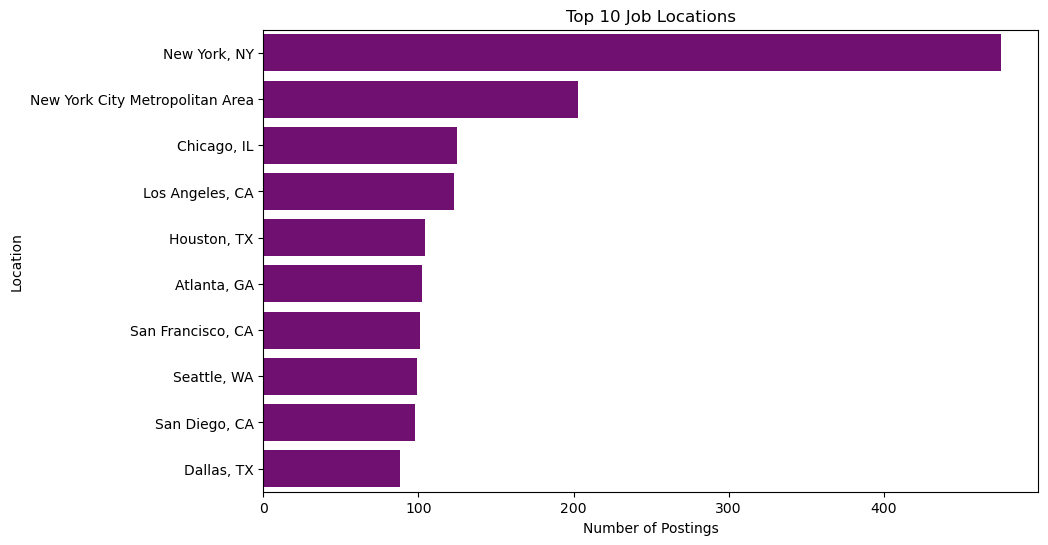

In [9]:
# Exclude "United States" from the dataset
filtered_locations = df[df['location'] != 'United States']

# Gather the top 10 locations with the highest number of job postings
top_locations = filtered_locations['location'].value_counts().head(10)

# Use horizontal bar plot to display findings
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_locations.values, 
    y=top_locations.index, 
    orient='h',  
    color='purple'
)

# Add title and axis labels on the plot
plt.title('Top 10 Job Locations')
plt.xlabel('Number of Postings')
plt.ylabel('Location')

# Display horizontal bar plot
plt.show()

### 5.2 Employment Type Distribution

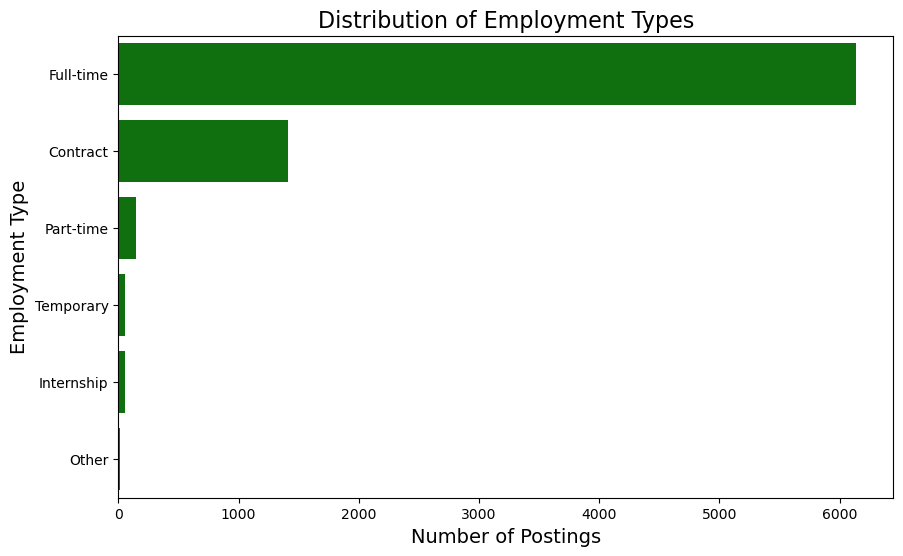

In [10]:
# Count number of job postings for each employment type
employment_types = df['formatted_work_type'].value_counts().reset_index()

# Rename columns
employment_types.columns = ['Employment Type', 'Count']

# Use horizontal bar plot to display findings
plt.figure(figsize=(10, 6))
sns.barplot(
    data=employment_types,
    x='Count',
    y='Employment Type',
    orient='h',  
    color='green'  
)

# Add title and axis labels on the plot
plt.title("Distribution of Employment Types", fontsize=16)
plt.xlabel("Number of Postings", fontsize=14)
plt.ylabel("Employment Type", fontsize=14)

# Display horizontal bar plot
plt.show()

### 5.3 Salary Distribution

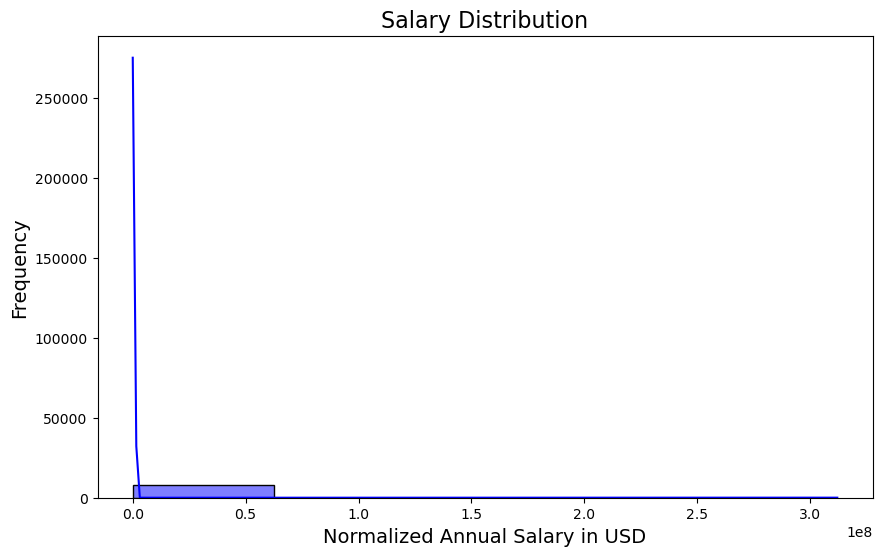

In [11]:
# Use histogram to display normalized salaries with a KDE
plt.figure(figsize=(10, 6))
sns.histplot(df['normalized_salary'], bins=5, kde=True, color='blue')

# Add title and axis labels on the histogram
plt.title('Salary Distribution', fontsize=16)
plt.xlabel('Normalized Annual Salary in USD', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display histogram
plt.show()

### 5.4 Correlation Analysis

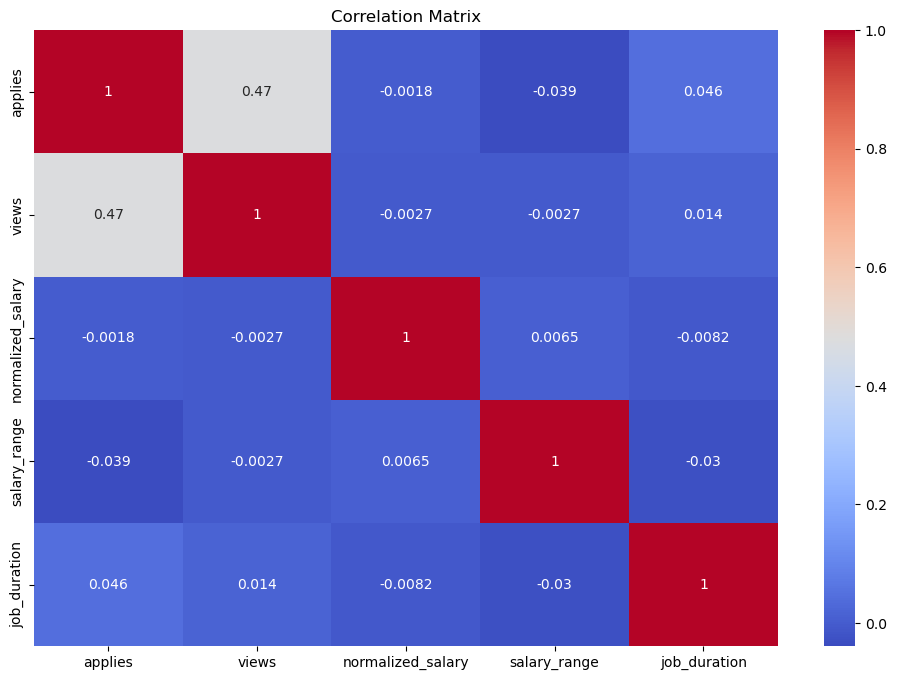

In [12]:
# Convert any columns not already converted to datetime format
for col in ['expiry', 'original_listed_time']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')  
    else:
        print(f"Column '{col}' is missing.")

# Check that 'salary_range' column is calculated
if 'salary_range' not in df.columns:
    if 'max_salary' in df.columns and 'min_salary' in df.columns:
        df['salary_range'] = df['max_salary'] - df['min_salary']
    else:
        print("Columns required to calculate 'salary_range' are missing.")

# Check that 'job_duration' column is calculated
if 'job_duration' not in df.columns:
    if 'expiry' in df.columns and 'original_listed_time' in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df['expiry']) and pd.api.types.is_datetime64_any_dtype(df['original_listed_time']):
            df['job_duration'] = (df['expiry'] - df['original_listed_time']).dt.days
        else:
            print("Make sure that 'expiry' and 'original_listed_time' are in datetime format.")
    else:
        print("Columns required to calculate 'job_duration' are missing.")

# Names of columns to fill with missing values
columns_to_fill = ['applies', 'views', 'normalized_salary', 'salary_range', 'job_duration']

# Fill in missing values
for col in columns_to_fill:
    if col in df.columns:
        df[col] = df[col].fillna(0)
    else:
        print(f"Column '{col}' is missing and cannot be filled.")

# Check if all required columns exist
# If so, then plot a correlation matrix
if all(col in df.columns for col in ['applies', 'views', 'normalized_salary', 'salary_range', 'job_duration']):
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        df[['applies', 'views', 'normalized_salary', 'salary_range', 'job_duration']].corr(),
        annot=True,
        cmap='coolwarm'
    )
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("Some columns required for the correlation matrix are missing.")

## Task 6 - Identifying Key Words in Job Descriptions

### Extracting Top Keywords from Job Descriptions

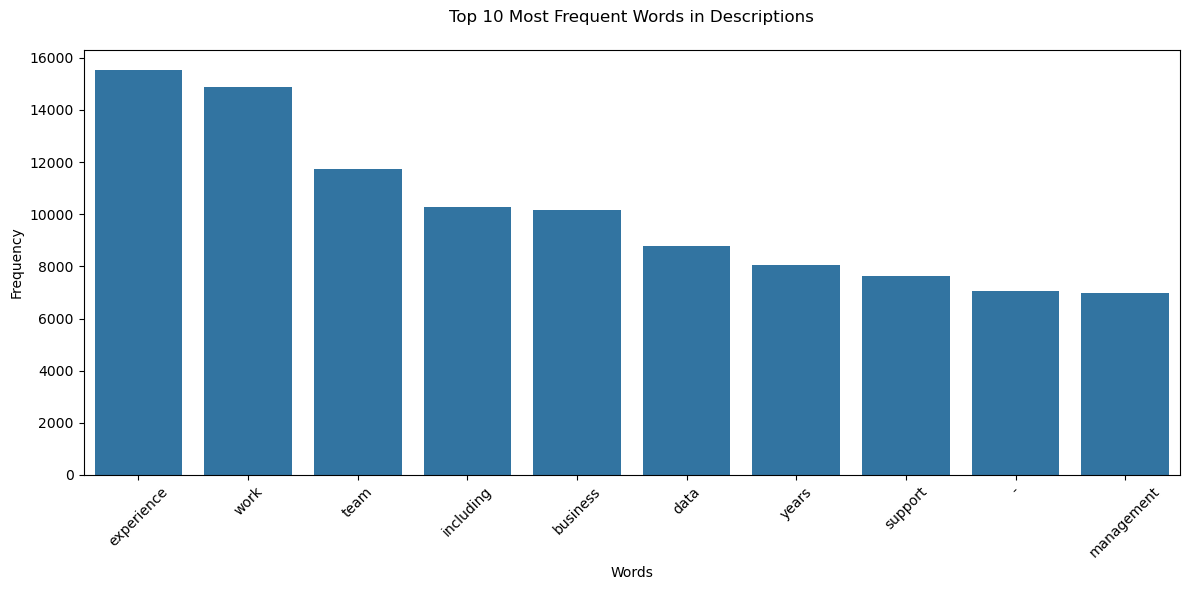

In [13]:
# Make sure description column exists
if 'description' in df.columns:
    df['description'] = df['description'].fillna("").astype(str)
else:
    raise ValueError("The 'description' column is missing.")

# Combine into string and split words
all_words = ' '.join(df['description']).split()

# Filter out stop words 
filtered_words = [word for word in all_words if word.lower() not in ENGLISH_STOP_WORDS]

# Count word frequencies
word_freq = Counter(filtered_words)

# Extract the top 10 most common words
top_10_words = dict(word_freq.most_common(10))

# Use a bar plot to display the top common words
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_10_words.keys()), y=list(top_10_words.values()))

# Add title and axis labels on the bar plot
plt.title('Top 10 Most Frequent Words in Descriptions', pad=20)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Display bar plot
plt.show()

## Task 7 - Feature Preparation for Predictive Modeling

### 7.1 Encoding Remote Work Availability and Setting Up Features

In [14]:
# Check and create 'remote_allowed_encoded' column if it doesn't already exist
if 'remote_allowed' in df.columns:
    # Assign 'Yes' to 1 and 'No' to 0, and handle missing values by filling them with 0
    df['remote_allowed_encoded'] = df['remote_allowed'].map({'Yes': 1, 'No': 0}).fillna(0)
else:
    # If the 'remote_allowed' column is missing, create 'remote_allowed_encoded' with default value 0
    print("The 'remote_allowed' column is missing. Creating 'remote_allowed_encoded' with default value 0.")
    df['remote_allowed_encoded'] = 0  # Default value if 'remote_allowed' is missing

# Define the features (input variables) and target (output variable)
features = ['normalized_salary', 'salary_range', 'job_duration', 'views', 'remote_allowed_encoded']
target = 'applies'

# Verify that all required features exist in the DataFrame
if not all(col in df.columns for col in features):
    missing_features = [col for col in features if col not in df.columns]
    raise ValueError(f"The following required features are missing: {missing_features}")

# Create feature matrix (X) and target variable (y)
X = df[features]
y = df[target]

### 7.2 Setting Up Training and Testing

In [15]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values in the features
from sklearn.impute import SimpleImputer

# Fit the imputer on the training set and transform it
imputer = SimpleImputer(strategy='median')  

# Apply the same transformation to the testing set
X_train = imputer.fit_transform(X_train)   

# Apply the same transformation to the testing set
X_test = imputer.transform(X_test)   

# Fill missing values in the target variable using the median
y_train = y_train.fillna(y_train.median())  

## Task 8 - Training and Evaluating Predictive Models

### 8.1 Model Training and Performance Evaluation

In [16]:
# Import required libraries for regression models and evaluation metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the models to test
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each of the models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model performance 
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Display the performance metrics of the model
    print(f"{name} Model Performance:")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  R²: {r2:.2f}\n")

Random Forest Model Performance:
  MAE: 5.27
  MSE: 244.78
  R²: 0.72

Linear Regression Model Performance:
  MAE: 10.13
  MSE: 747.09
  R²: 0.15

Gradient Boosting Model Performance:
  MAE: 5.32
  MSE: 293.49
  R²: 0.67



### 8.2 Storing Predictions and Metrics in a Database

In [17]:
# Use Random Forest model to predict on the test set
y_pred_rf = models["Random Forest"].predict(X_test)

# Create a DataFrame to compare actual and predicted values along with the prediction errors
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rf,
    'Error': y_test - y_pred_rf
})

# Calculate metrics for the Random Forest model
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R^2'],
    'Value': [
        mean_absolute_error(y_test, y_pred_rf),
        mean_squared_error(y_test, y_pred_rf),
        r2_score(y_test, y_pred_rf)
    ]
})

# Save the model prediction results and metrics into a SQLite database
conn = sqlite3.connect('linkedin_postings.db')
results_df.to_sql('job_posting_predictions', conn, if_exists='replace', index=False)
metrics_df.to_sql('model_metrics', conn, if_exists='replace', index=False)

# Confirm that data has been successfully saved
print("Prediction results and model metrics stored in SQLite database.")
print("Sample Predictions:", results_df.head())
print("Model Metrics:", metrics_df)

# Close the database connection
conn.close()

Prediction results and model metrics stored in SQLite database.
Sample Predictions:       Actual  Predicted  Error
1142     7.0      12.42  -5.42
4257     1.0       1.10  -0.10
2166     5.0       4.21   0.79
1677     1.0       1.08  -0.08
7674     5.0       2.38   2.62
Model Metrics:   Metric       Value
0    MAE    5.273857
1    MSE  244.781608
2    R^2    0.721835


## Task 9 - Visualizing Model Results

### 9.1 Feature Importance Visualization

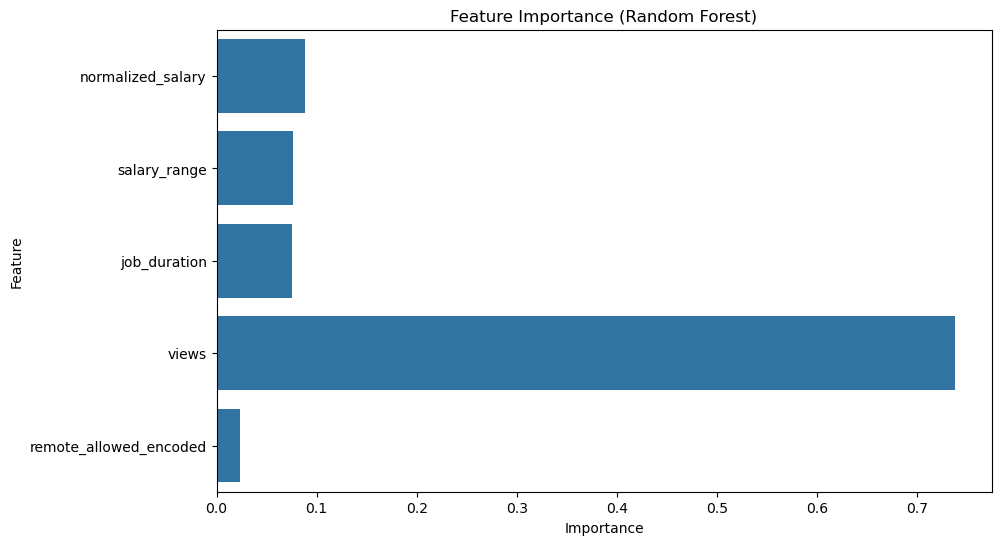

In [18]:
# Ensure the Random Forest model is trained and retrieve feature importances
rf_model = models.get("Random Forest")  # Get the Random Forest model from the models dictionary
if rf_model is not None:
    importances = rf_model.feature_importances_
else:
    raise ValueError("Random Forest model is not defined or trained.")

# Ensure the 'features' list is defined and check if is consistent with the training data
if 'features' not in globals():
    raise ValueError("The 'features' list is not defined.")

# Match feature names with their corresponding importance values
used_features = features[:len(importances)]

# Use a bar chart to plot the feature importance 
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=used_features, orient='h')

# Add title and axis labels on the bar chart
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Display bar chart
plt.show()

### 9.2 Actual vs. Predicted Scatter Plot

In [ ]:
# Generate predictions using the trained Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Create a scatter plot to compare actual vs predicted applications
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', lw=2, label='Ideal Fit')

# Add title and axis labels for the scatter plot
plt.title('Actual vs Predicted Applications (Random Forest)')
plt.xlabel('Actual Applications')
plt.ylabel('Predicted Applications')
plt.legend()
plt.grid(True)

# Display scatter plot
plt.show()

## Task 10 - Exploratory Visualizations

### 10.1 Applications vs. Views by Work Type

In [ ]:
# Create a scatter plot to compare views and applications by work type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='views', y='applies', hue='formatted_work_type', alpha=0.7)

# Add title and axis labels for the scatter plot
plt.title("Views vs Applications by Work Type")
plt.xlabel("Number of Views")
plt.ylabel("Number of Applications")
plt.legend(title="Work Type")

# Display scatter plot
plt.show()

### 10.2 Experience Level Distribution

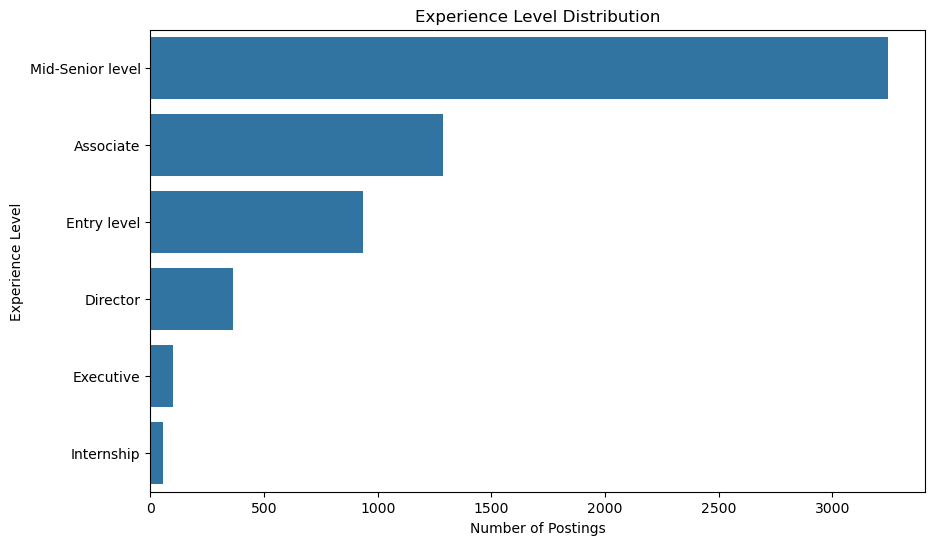

In [21]:
# Count the number of job postings for each experience level
experience_level = df['formatted_experience_level'].value_counts()

# Create a horizontal bar chart to visualize the distribution of different experience levels
plt.figure(figsize=(10, 6))
sns.barplot(x=experience_level.values, y=experience_level.index, orient='h')  # Horizontal bar chart

# Add title and axis labels on the bar chart
plt.title("Experience Level Distribution")
plt.xlabel("Number of Postings")
plt.ylabel("Experience Level")

# Display the bar chart
plt.show()